# I. Data Colletion

In [16]:
#import necessary liblaries
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, recall_score, f1_score
import shutil
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, classification_report

In [7]:
!unzip /content/Philippines_Fish_Market_Dataset.zip -d ./phpublicfish

Archive:  /content/Philippines_Fish_Market_Dataset.zip
   creating: ./phpublicfish/Philippines Fish Market Dataset/Bangus/
  inflating: ./phpublicfish/Philippines Fish Market Dataset/Bangus/AUTOLYSIS-1-_JPG.rf.8183c7d7c92188cd158433c714fcd41e.jpg  
  inflating: ./phpublicfish/Philippines Fish Market Dataset/Bangus/AUTOLYSIS-10-_JPG.rf.fe35e5affd7efc3eb060ed7bddcc428a.jpg  
  inflating: ./phpublicfish/Philippines Fish Market Dataset/Bangus/AUTOLYSIS-11-_JPG.rf.7f4eb7dda3991a56906f6cccee7ee30a.jpg  
  inflating: ./phpublicfish/Philippines Fish Market Dataset/Bangus/AUTOLYSIS-11-_JPG.rf.cca3289ad851fcdf11f6b11d9b7ed78f.jpg  
  inflating: ./phpublicfish/Philippines Fish Market Dataset/Bangus/AUTOLYSIS-14-_JPG.rf.426c36b47bc527aa3919e0e6f45ede5e.jpg  
  inflating: ./phpublicfish/Philippines Fish Market Dataset/Bangus/AUTOLYSIS-16-_JPG.rf.34e5d60533de97af9c0b923ec2a56d0a.jpg  
  inflating: ./phpublicfish/Philippines Fish Market Dataset/Bangus/AUTOLYSIS-2-_JPG.rf.75446eefd816a6971ca330251f25c

In [17]:
#get dataseet directory
dataset = '/content/phpublicfish/Philippines Fish Market Dataset'

# Inspect dataset directories
class_names = ['Bangus', 'Dalagang bukid', 'Hiwas', 'Tilapia', 'Tulingan']
for class_name in class_names:
    class_dir = os.path.join(dataset, class_name)
    print(f"{class_name} images: {os.listdir(class_dir)[:5]}")

Bangus images: ['BLOATED-31-_JPG.rf.8b2680a8cfb3983b952a3295db6197e8.jpg', 'FRESH-60-_JPG.rf.6c7d41d7349b5405e23d48892f73f706.jpg', 'Bangus 125.jpg', 'Bangus 22.jpg', 'PUTREFACTION-58-_JPG.rf.c19ad8116b61e7289564b0ee989ed346.jpg']
Dalagang bukid images: ['20241212_174000.jpg', '20241212_174010.jpg', 'shutterstock_461757256-e1479837465232-800x500.jpg', 'images (1).jpg', '20241212_174031(0).jpg']
Hiwas images: ['h10.png', 'images (15).jpg', '20241212_174147.jpg', 'images (1).jpg', 'h5.png']
Tilapia images: ['Tilapia 37.jpg', 't14.png', '24_jpg.rf.c2f45b7d05985acefe48bc6fdbeb7f46.jpg', 't28_jpg.rf.9393c35fadeb1db0351e49325c6027c6.jpg', '49_jpg.rf.064eb23b299d1706c905debc9065eac8.jpg']
Tulingan images: ['Screenshot-2024-10-20-212712_png.rf.9de6cda6a368db88b54b83e0a4b5bb73.jpg', '20241212_173815(0).jpg', 'u36.png', 'images (1).jpg', '20241212_173711.jpg']


In [18]:
# Data preparation
image_size = (224, 224)
batch_size = 32

train_dir = '/content/phpublicfish/Philippines Fish Market Dataset'
train_datagen = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create training and validation generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)

Found 1448 images belonging to 5 classes.
Found 358 images belonging to 5 classes.


In [19]:
# Check class mapping from ImageDataGenerator
print("Class Indices:", train_generator.class_indices)
print("Class Mode:", train_generator.class_mode)
print("Classes (first 10):", train_generator.classes[:10])
print("Filenames (first 5):", train_generator.filenames[:5])
print("Total Samples:", train_generator.samples)

# Invert the class_indices dictionary to map indices to class names
idx_to_class = {v: k for k, v in train_generator.class_indices.items()}

Class Indices: {'Bangus': 0, 'Dalagang bukid': 1, 'Hiwas': 2, 'Tilapia': 3, 'Tulingan': 4}
Class Mode: sparse
Classes (first 10): [0 0 0 0 0 0 0 0 0 0]
Filenames (first 5): ['Bangus/BLOATED-39-_JPG.rf.e02cdea6b2c2fd6d1c4a96c869a3f0ae.jpg', 'Bangus/BLOATED-4-_JPG.rf.8333de51b816f4010add464a9ac0cf23.jpg', 'Bangus/BLOATED-4-_JPG.rf.8fae842933e9b609bfd2f022a51bb1a5.jpg', 'Bangus/BLOATED-40-_JPG.rf.bb6376340a33cd663513a01f300f29be.jpg', 'Bangus/BLOATED-40-_JPG.rf.bf113b24f52a4e09ee0575835717501e.jpg']
Total Samples: 1448


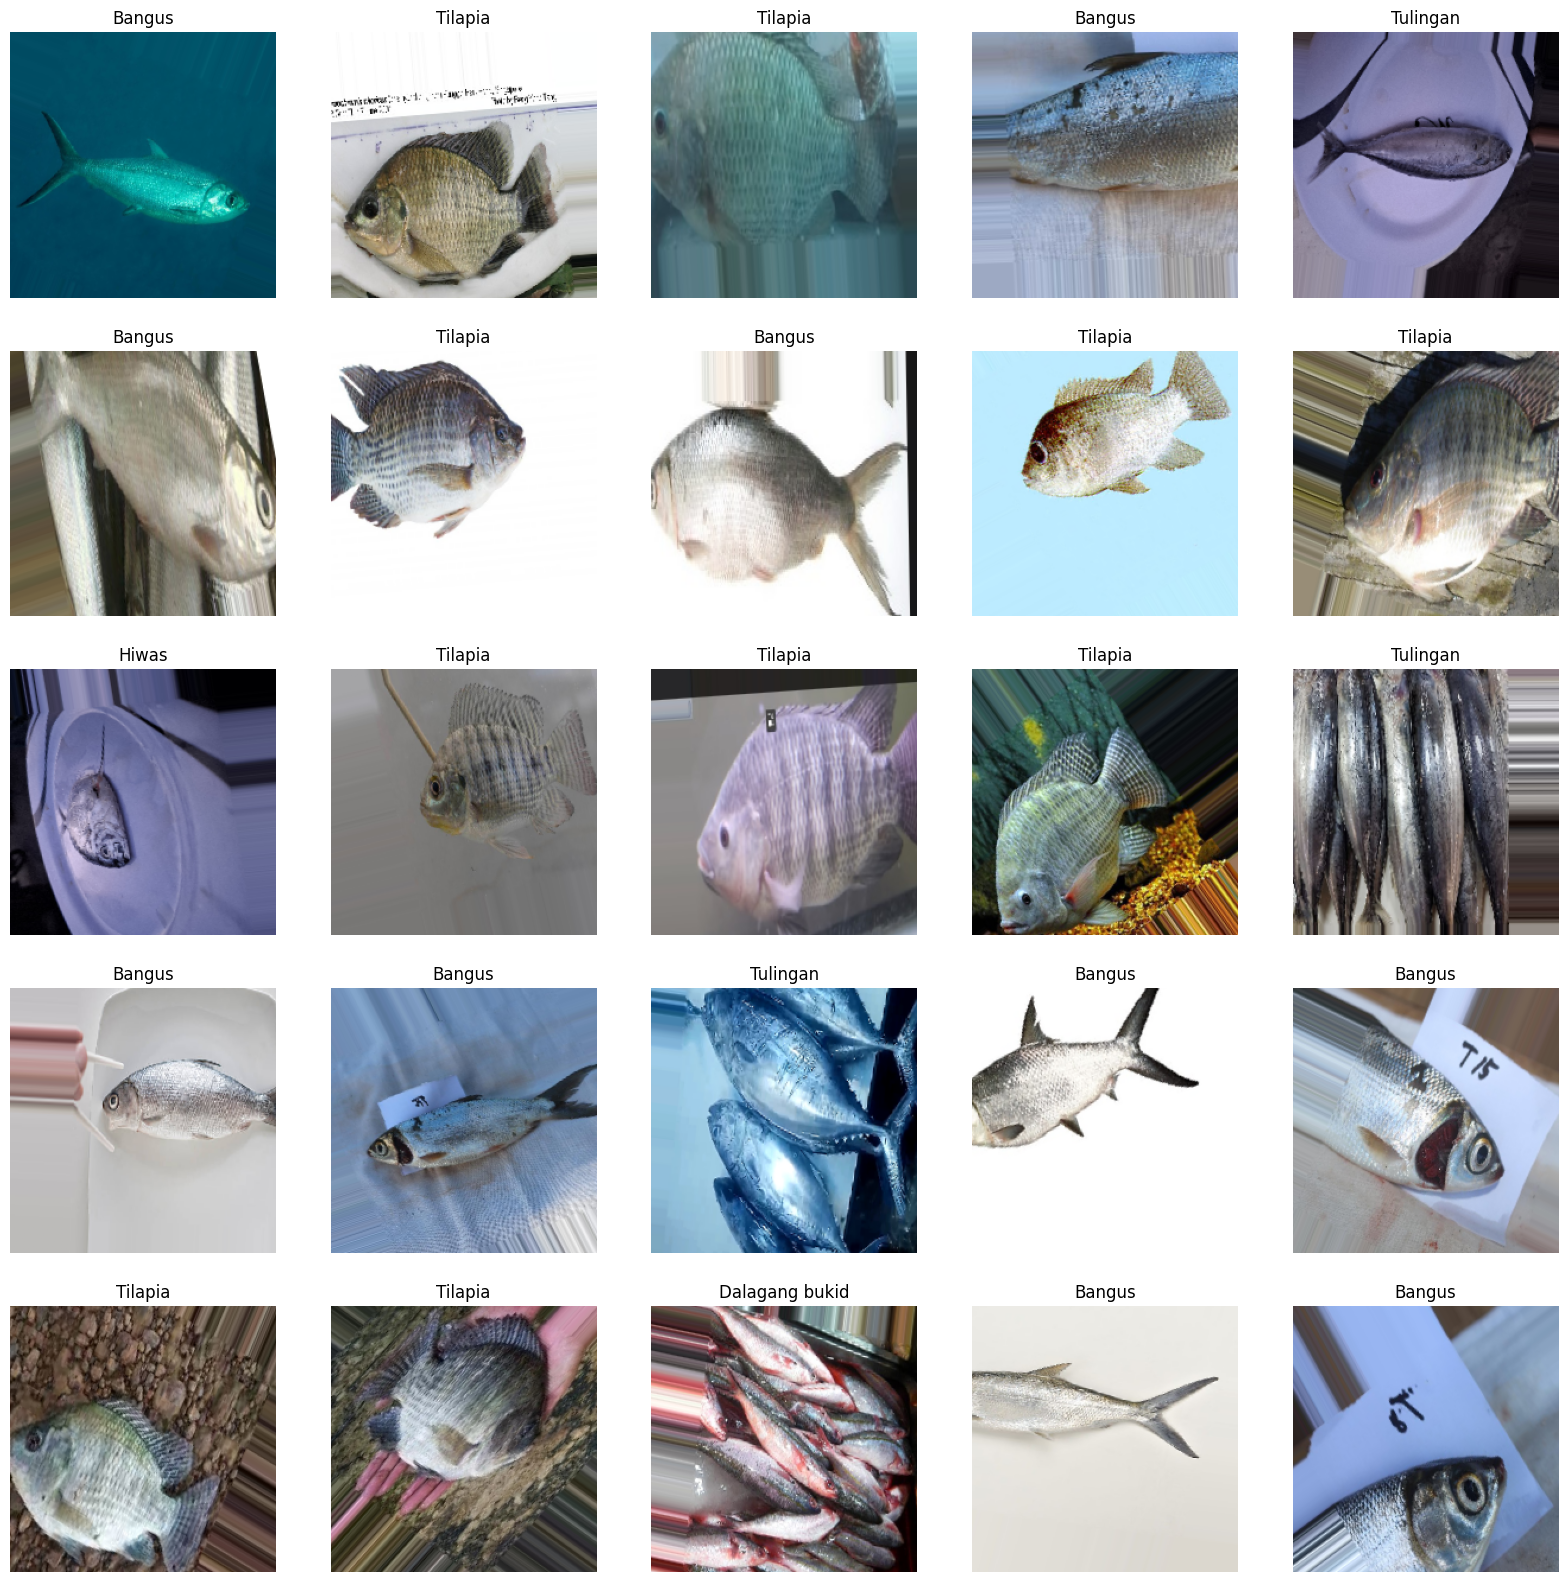

In [20]:
# Set up the plot parameters
nrows = 5
ncols = 5
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

# Get a batch of images
next_batch = train_generator.__next__()

# Plot the images with correct labels
for i in range(0, nrows*ncols):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.axis('Off')
    plt.imshow(next_batch[0][i])
    class_idx = next_batch[1][i]
    plt.title(idx_to_class[int(class_idx)])  # Use the corrected class labels

plt.show()

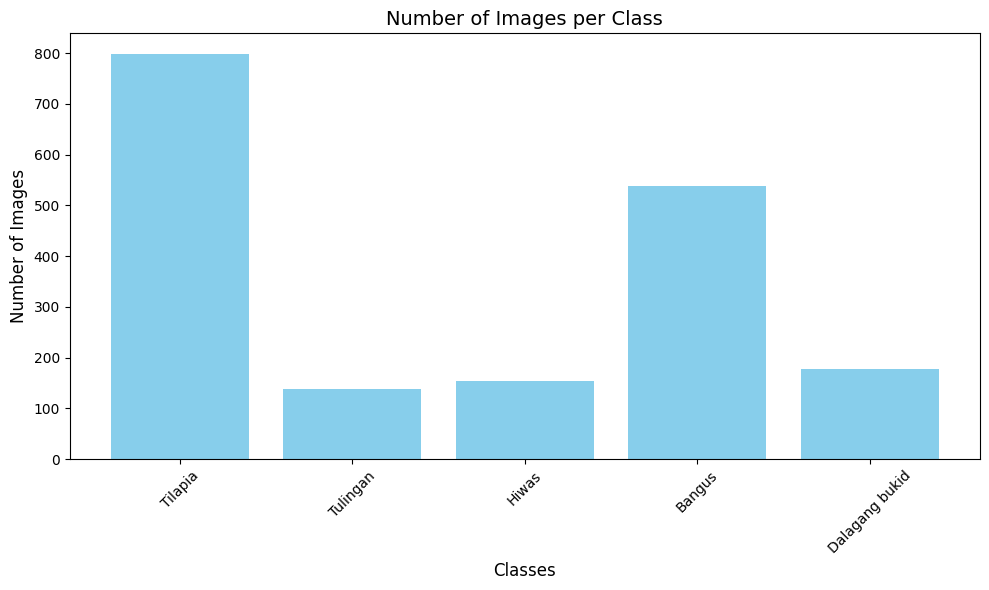


Exact Image Counts per Class:
Class 'Bangus' (Index 0): 538 images
Class 'Dalagang bukid' (Index 1): 177 images
Class 'Hiwas' (Index 2): 153 images
Class 'Tilapia' (Index 3): 799 images
Class 'Tulingan' (Index 4): 139 images


In [24]:
class_counts = {}

# Loop through each subfolder (class)
for class_name in os.listdir(dataset):
    class_path = os.path.join(dataset, class_name)

    # Ensure it's a directory
    if os.path.isdir(class_path):
        # Count image files (supports .jpg, .jpeg, .png)
        image_count = len([file for file in os.listdir(class_path)
                           if file.lower().endswith(('.png', '.jpg', '.jpeg'))])
        class_counts[class_name] = image_count

# Step 3: Plot the class distribution
plt.figure(figsize=(10, 6))  # Set figure size
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')

# Add labels and title
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Number of Images per Class', fontsize=14)
plt.xticks(rotation=45)  # Rotate class names for better visibility
plt.tight_layout()

# Show the plot
plt.show()

print("\nExact Image Counts per Class:")
for class_idx, class_name in idx_to_class.items():
  count = class_counts.get(class_name, 0)
  print(f"Class '{class_name}' (Index {class_idx}): {count} images")

In [ ]:
# Load MobileNetV2 model pre-trained on ImageNet
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Define new model
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(5, activation='softmax'))  # For the 5 classes

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Compile the model
#used sparse categorical crossentropy for multiclass classification
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=10, validation_data=validation_generator, verbose=1)

# Evaluate the model
test_loss, test_acc = model.evaluate(validation_generator, verbose=0)
print(f'Test accuracy: {test_acc}')


# Get predictions and calculate metrics
y_true = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

# Save the trained model
model.save("FishClassifier.h5")
print("Model saved as FishClassifier.h5")

In [ ]:
#Result from model training
print("\nResults:")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-score: {f1_score:.4f}")

In [ ]:
  # Plot training and validation metrics
  plt.figure(figsize=(12, 4))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Accuracy over Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Loss over Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

  # Predictions and evaluation
  y_true = validation_generator.classes
  y_pred = model.predict(validation_generator)
  y_pred_classes = np.argmax(y_pred, axis=1)

  print("\nClassification Report:")
  print(classification_report(y_true, y_pred_classes, target_names=class_names))

  # Confusion matrix
  conf_matrix = confusion_matrix(y_true, y_pred_classes)
  plt.figure(figsize=(8, 6))
  plt.imshow(conf_matrix, cmap='Blues')
  plt.title('Confusion Matrix')
  plt.colorbar()
  plt.xticks(range(len(class_names)), class_names, rotation=45)
  plt.yticks(range(len(class_names)), class_names)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.show()

In [ ]:
# Load the saved model
model_load = load_model("FishClassifier.h5")

In [ ]:
!unzip /content/Test_Sample.zip -d ./sample_test

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


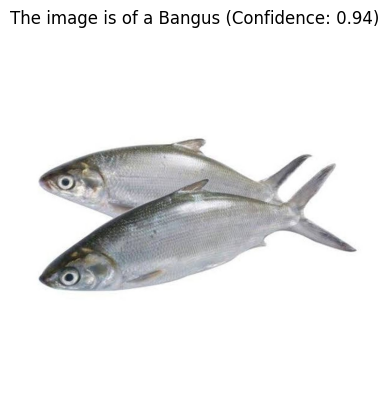

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


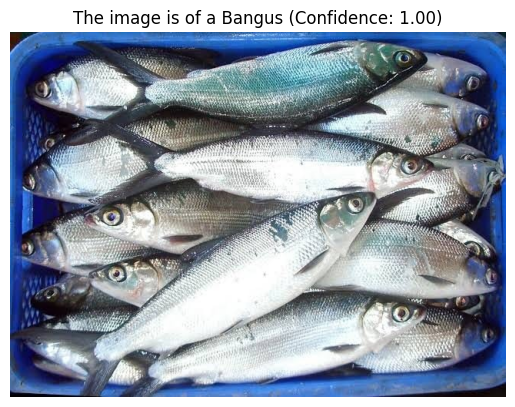

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


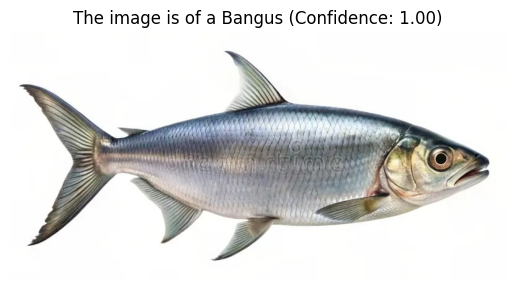

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


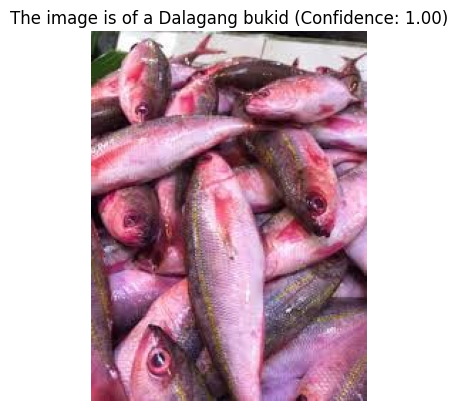

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


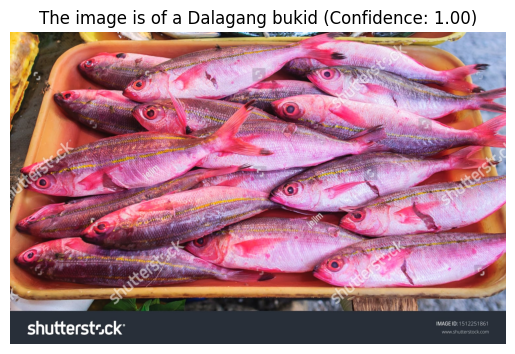

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


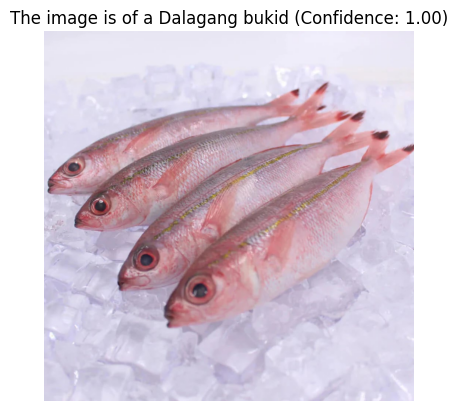

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


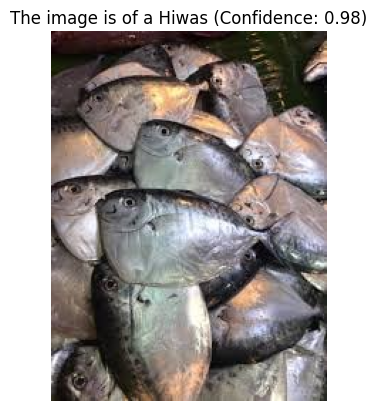

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


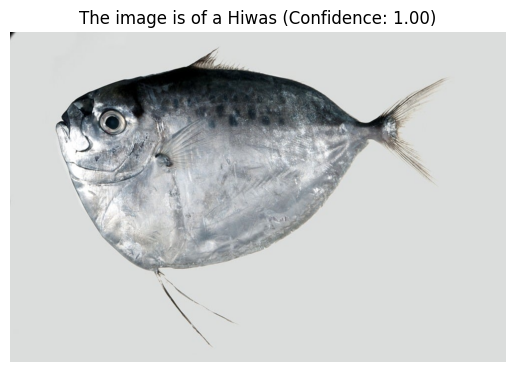

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


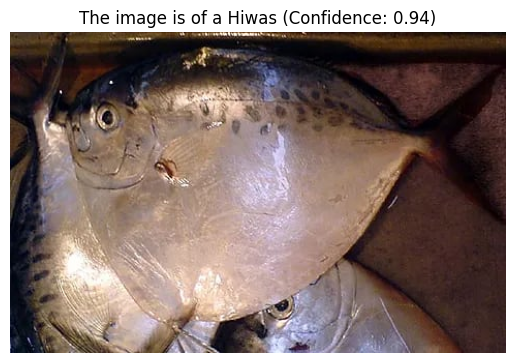

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


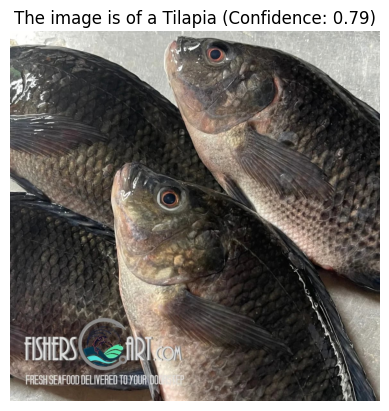

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


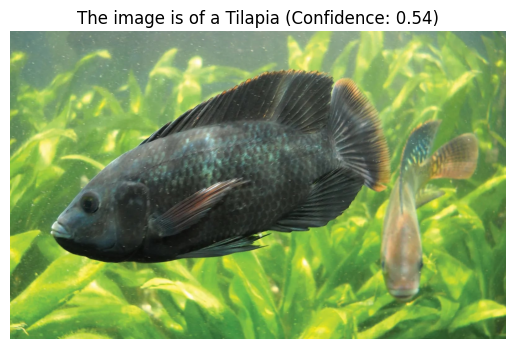

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


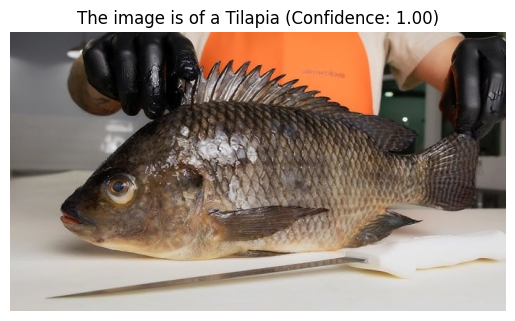

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


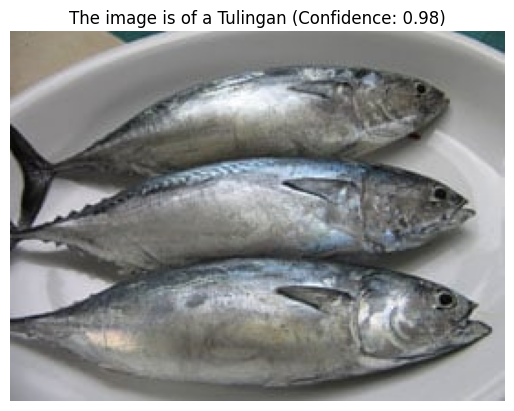

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


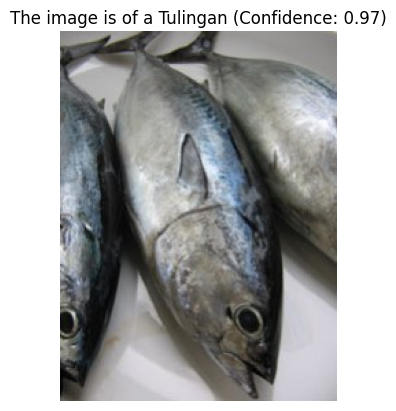

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


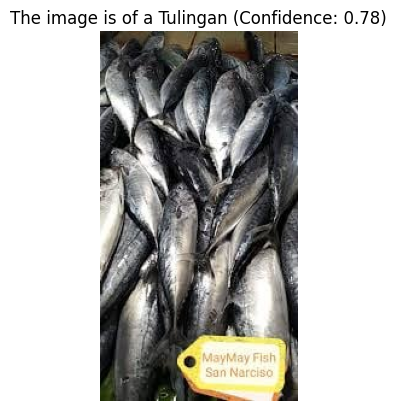

In [ ]:
def classify_image(image_paths, model, train_generator, threshold=0.5):

    # Get class indices and labels
    class_indices = train_generator.class_indices
    labels = {v: k for k, v in class_indices.items()}

    for img_path in image_paths:
        img = image.load_img(img_path, target_size=(224, 224))  # Resize to match model input size
        img_array = image.img_to_array(img)  # Convert to array
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = img_array / 255.0  # Normalize the image

        # Make predictions using the trained model
        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction, axis=1)[0]  # Get class with highest probability
        confidence = np.max(prediction)  # Get the highest probability

        if confidence < threshold:
            label = "None of the common fishes"
        else:
            label = labels[predicted_class]

        # Display the image with the predicted label
        plt.imshow(image.load_img(img_path))  # Display the original image
        plt.title(f"The image is of a {label} (Confidence: {confidence:.2f})")
        plt.axis('off')  # Hide the axis
        plt.show()

# Bangus
img_paths = ["/content/sample_test/Test_Sample/Bangus/b1.jpg","/content/sample_test/Test_Sample/Bangus/b2.jpg","/content/sample_test/Test_Sample/Bangus/b3.jpg"]
classify_image(img_paths, model, train_generator, threshold=0.5)

# Dalangang Bukid
img_paths = ["/content/sample_test/Test_Sample/Dalagang bukid/d1.jpg","/content/sample_test/Test_Sample/Dalagang bukid/d2.jpg","/content/sample_test/Test_Sample/Dalagang bukid/d3.jpg"]
classify_image(img_paths, model, train_generator, threshold=0.5)

# Hiwas
img_paths = ["/content/sample_test/Test_Sample/Hiwas/h1.jpg","/content/sample_test/Test_Sample/Hiwas/h2.jpg","/content/sample_test/Test_Sample/Hiwas/h3.jpg"]
classify_image(img_paths, model, train_generator, threshold=0.5)

# Tilapia
img_paths = ["/content/sample_test/Test_Sample/Tilapia/t1.jpg","/content/sample_test/Test_Sample/Tilapia/t2.jpg","/content/sample_test/Test_Sample/Tilapia/t3.jpg"]
classify_image(img_paths, model, train_generator, threshold=0.5)

# Tulingan
img_paths = ["/content/sample_test/Test_Sample/Tulingan/u1.jpg","/content/sample_test/Test_Sample/Tulingan/u2.jpg","/content/sample_test/Test_Sample/Tulingan/u3.jpg"]
classify_image(img_paths, model, train_generator, threshold=0.5)
